In this implementation we will be learning the unigram and bigram data of Apple News data using CNN-LSTM model and predicting the direction of the stock.

In [59]:
import numpy as np
import tensorflow as tf
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import Sequential
from keras.layers import LSTM,Conv1D,Conv2D,MaxPooling2D,MaxPooling1D,Flatten
from keras.layers import Dense, Dropout
import pandas as pd
from keras.optimizers import Adam
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
#from datetime import datetime

from tensorflow.compat.v1.keras.layers import CuDNNLSTM,Bidirectional
seed=42

In [60]:
unigram_data = pd.read_csv('dtm_apple_unigram_chi2.csv')
bigram_data = pd.read_csv('dtm_apple_bigram_chi2.csv')
unigram_data.iloc[:, -1] = unigram_data.iloc[:, -1].replace(-1, 0)
bigram_data.iloc[:, -1] = bigram_data.iloc[:, -1].replace(-1, 0)
dfuni = unigram_data
dfbi = bigram_data
bigram_data.shape

(21960, 1001)

In [61]:
#Variables for training
df_for_training_uni = dfuni.astype(float)
df_for_training_bi = dfbi.astype(float)

In [62]:
trainX_uni = []
trainY_uni = []
trainX_bi = []
trainY_bi = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 5  # Number of past days we want to use to predict the future.

# Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(n_past, len(df_for_training_uni) - n_future + 1):

    X_sequence = df_for_training_uni.iloc[i - n_past:i, : ]
    trainX_uni.append(X_sequence)

    # Extract the target values (trainY)
    y_sample = df_for_training_uni.iloc[i + n_future - 1:i + n_future, [-1]]  # Direction
    trainY_uni.append(y_sample)

trainX_uni, trainY_uni = np.array(trainX_uni), np.array(trainY_uni)
for i in range(n_past, len(df_for_training_bi) - n_future + 1):

    X_sequence = df_for_training_bi.iloc[i - n_past:i, : ]
    trainX_bi.append(X_sequence)

    # Extract the target values (trainY)
    y_sample = df_for_training_bi.iloc[i + n_future - 1:i + n_future, [-1]]  # Direction
    trainY_bi.append(y_sample)

trainX_bi, trainY_bi = np.array(trainX_bi), np.array(trainY_bi)


print('TrainX Unigram shape = {}.'.format(trainX_uni.shape))
print('TrainY Unigram shape = {}.'.format(trainY_uni.shape))
print('TrainX Bigram shape = {}.'.format(trainX_bi.shape))
print('TrainY Bigram shape = {}.'.format(trainY_bi.shape))

TrainX Unigram shape = (21955, 5, 1001).
TrainY Unigram shape = (21955, 1, 1).
TrainX Bigram shape = (21955, 5, 1001).
TrainY Bigram shape = (21955, 1, 1).


Training and Testing data

In [63]:
X_train_lstm_uni, X_test_lstm_uni, y_train_lstm_uni, y_test_lstm_uni = train_test_split(trainX_uni, trainY_uni, test_size=0.2, shuffle=False)
X_train_lstm_bi, X_test_lstm_bi, y_train_lstm_bi, y_test_lstm_bi = train_test_split(trainX_bi, trainY_bi, test_size=0.2, shuffle=False)

Training and Validation Data

In [64]:
X_train_lstm_uni, X_val_lstm_uni, y_train_lstm_uni, y_val_lstm_uni = train_test_split(X_train_lstm_uni, y_train_lstm_uni, test_size=0.1, shuffle=False)
X_train_lstm_bi, X_val_lstm_bi, y_train_lstm_bi, y_val_lstm_bi = train_test_split(X_train_lstm_bi, y_train_lstm_bi, test_size=0.1, shuffle=False)

Model Architecture

In [65]:
def build_model(input_shape):
    tf.random.set_seed(seed)
    cnn_lstm_model = Sequential()

    cnn_lstm_model.add(Conv1D(filters=128, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    cnn_lstm_model.add(MaxPooling1D(pool_size=2, strides=2))

    cnn_lstm_model.add(Conv1D(filters=64, kernel_size=2, strides=1, padding='valid'))
    cnn_lstm_model.add(MaxPooling1D(pool_size=1, strides=2))

    cnn_lstm_model.add(Bidirectional(LSTM(256, return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))
    cnn_lstm_model.add(Bidirectional(LSTM(256, return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))

    cnn_lstm_model.add(Dense(32, activation='relu'))

    cnn_lstm_model.add(Dense(1, activation='sigmoid'))

    cnn_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    cnn_lstm_model.summary()
    return cnn_lstm_model

In [66]:
# fit the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
cnn_lstm_model_uni=build_model((X_train_lstm_uni.shape[1],X_train_lstm_uni.shape[2]))
history_uni = cnn_lstm_model_uni.fit(X_train_lstm_uni, y_train_lstm_uni, epochs=50, batch_size=64, validation_data=(X_val_lstm_uni, y_val_lstm_uni), verbose=1,callbacks=[early_stopping] )
cnn_lstm_model_bi=build_model((X_train_lstm_bi.shape[1],X_train_lstm_bi.shape[2]))
history_bi = cnn_lstm_model_bi.fit(X_train_lstm_bi, y_train_lstm_bi, epochs=50, batch_size=64, validation_data=(X_val_lstm_bi, y_val_lstm_bi), verbose=1,callbacks=[early_stopping] )

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 4, 128)            256384    
                                                                 
 max_pooling1d_16 (MaxPooli  (None, 2, 128)            0         
 ng1D)                                                           
                                                                 
 conv1d_17 (Conv1D)          (None, 1, 64)             16448     
                                                                 
 max_pooling1d_17 (MaxPooli  (None, 1, 64)             0         
 ng1D)                                                           
                                                                 
 bidirectional_16 (Bidirect  (None, 1, 512)            657408    
 ional)                                                          
                                                      

Unigram Model Training and Validation Loss

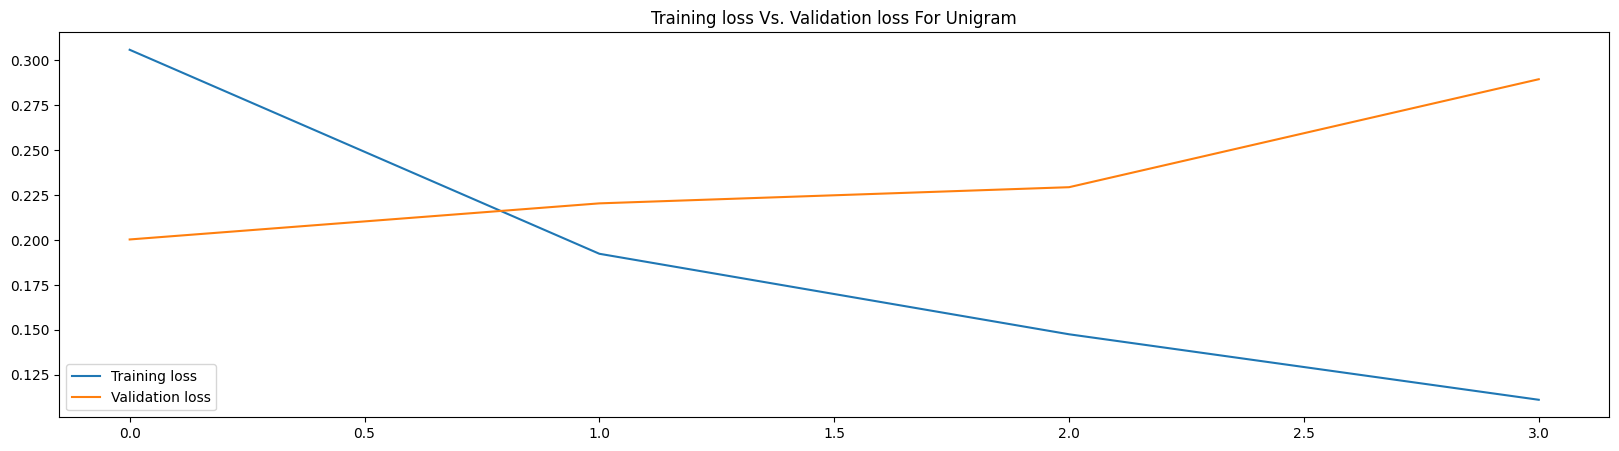

In [67]:
plt.figure(figsize=(20,5))
plt.plot(history_uni.history['loss'], label='Training loss')
plt.plot(history_uni.history['val_loss'], label='Validation loss')
plt.title('Training loss Vs. Validation loss For Unigram')
plt.legend()

Bigram Model Training and Validation Loss

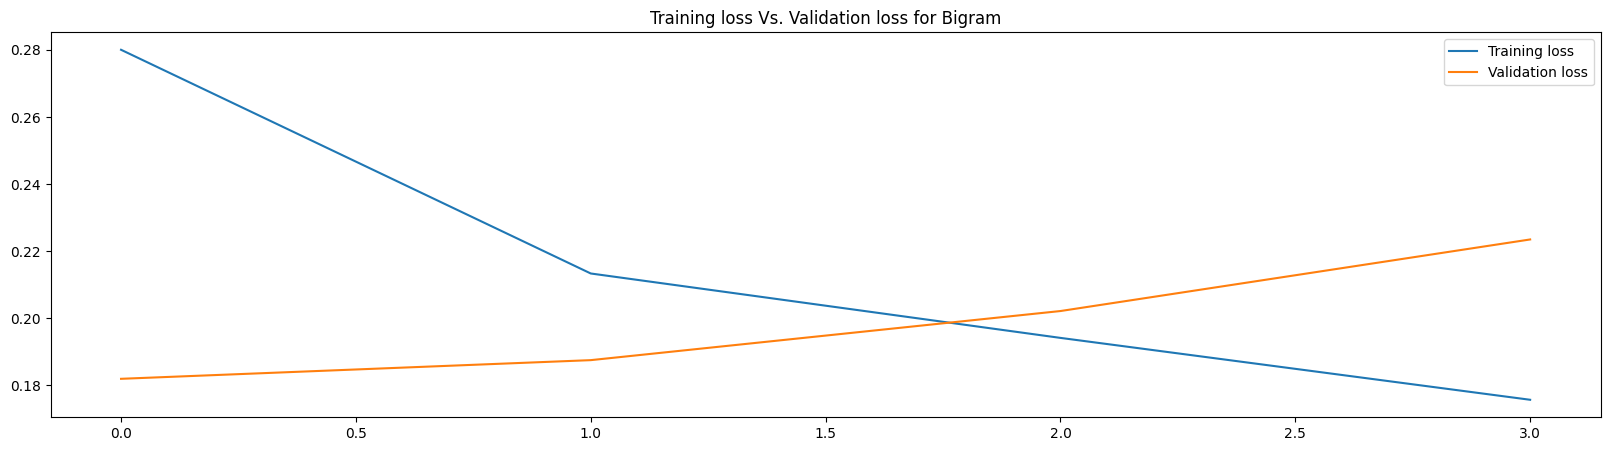

In [68]:
plt.figure(figsize=(20,5))
plt.plot(history_bi.history['loss'], label='Training loss')
plt.plot(history_bi.history['val_loss'], label='Validation loss')
plt.title('Training loss Vs. Validation loss for Bigram')
plt.legend()

Unigram Model Accuracies

In [69]:
train_accuracy = history_uni.history['accuracy'][-1]
val_accuracy = history_uni.history['val_accuracy'][-1]
test_loss, test_accuracy_uni = cnn_lstm_model_uni.evaluate(X_test_lstm_uni, y_test_lstm_uni)
print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)
print("Test Accuracy:", test_accuracy_uni)

138/138 [==============================] - 1s 5ms/step - loss: 0.2054 - accuracy: 0.9478
Training Accuracy: 0.9609666466712952
Validation Accuracy: 0.9225953221321106
Test Accuracy: 0.947847843170166


Bigram Model Accuracies

In [70]:
train_accuracy = history_bi.history['accuracy'][-1]
val_accuracy = history_bi.history['val_accuracy'][-1]
test_loss, test_accuracy_bi = cnn_lstm_model_bi.evaluate(X_test_lstm_bi, y_test_lstm_bi)
print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)
print("Test Accuracy:", test_accuracy_bi)

138/138 [==============================] - 1s 8ms/step - loss: 0.1868 - accuracy: 0.9565
Training Accuracy: 0.9473018050193787
Validation Accuracy: 0.9288560152053833
Test Accuracy: 0.9565019607543945


Unigram Confusion Matrix

138/138 [==============================] - 2s 4ms/step


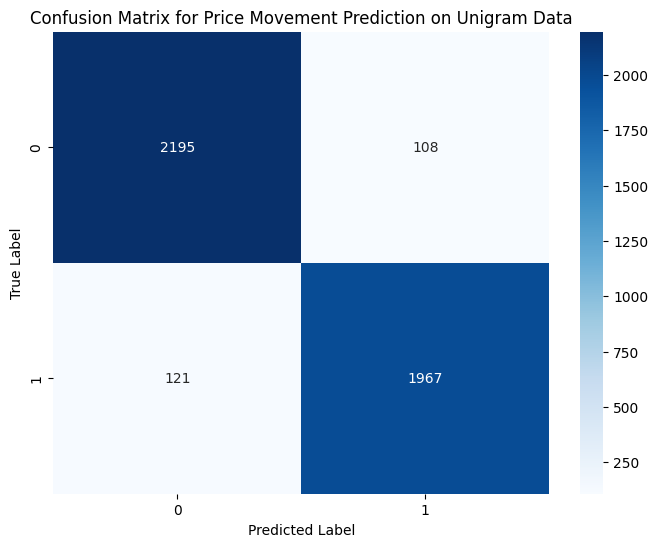

Testing Accuracy: 0.947847843170166


In [71]:
threshold = 0.5  # Adjust this threshold as needed
y_pred_movement = cnn_lstm_model_uni.predict(X_test_lstm_uni)
y_pred_movement_binary = (y_pred_movement >= threshold).astype(int)
y_pred_movement_binary = np.array(y_pred_movement_binary)
y_test_lstm_uni = np.squeeze(y_test_lstm_uni)
y_pred_movement_binary = np.squeeze(y_pred_movement_binary)

conf_matrix = confusion_matrix(y_test_lstm_uni, y_pred_movement_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix for Price Movement Prediction on Unigram Data')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("Testing Accuracy:", test_accuracy_uni)

Bigram Confusion Matrix

138/138 [==============================] - 1s 4ms/step


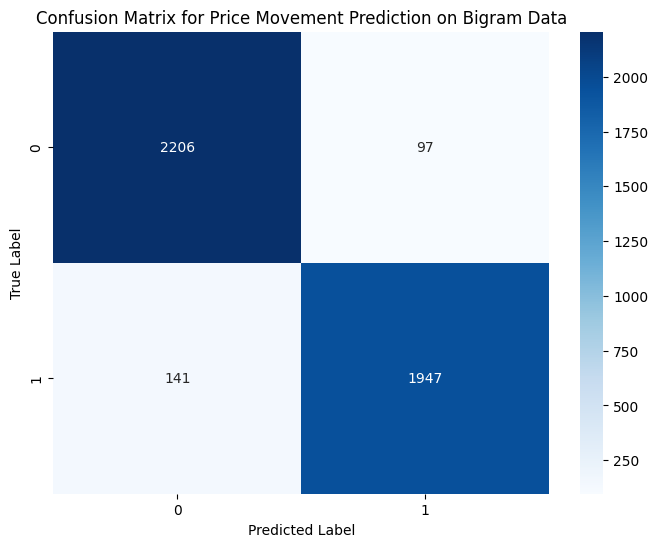

Testing Accuracy: 0.9565019607543945


In [72]:
threshold = 0.5  # Adjust this threshold as needed
y_pred_movement = cnn_lstm_model_uni.predict(X_test_lstm_bi)
y_pred_movement_binary = (y_pred_movement >= threshold).astype(int)
y_pred_movement_binary = np.array(y_pred_movement_binary)
y_test_lstm_bi = np.squeeze(y_test_lstm_bi)
y_pred_movement_binary = np.squeeze(y_pred_movement_binary)

conf_matrix = confusion_matrix(y_test_lstm_bi, y_pred_movement_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix for Price Movement Prediction on Bigram Data')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("Testing Accuracy:", test_accuracy_bi)